# Image Classification Using the Features of a Pre-trained Network

This code partially follows the keras blog post "Building powerful image classification models using very little data". Breast Cancer Histopathological Database (BreakHis) has been used as the dataset. It can be found at https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/. 

### Rationale
Although CNNs are an excellent approach to image classification and have outperformed many other methods, they do not show much success for biological datasets. This is because the labelled data in biological datasets is comparatively small and not sufficient to train a deep network.
To overcome this problem, Transfer Learning can be used, which involves extracting features using a pre-trained network (here, VGG16 pre-trained on the ImageNet datset is used), and removing the last fully connected layer, in place of which, a different classifier may be used. How well, the chosen pre-trained CNN can classify images belonging to a different domain than those it was trained on, can also be studied.

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras import applications
from keras import optimizers
from keras.layers.normalization import BatchNormalization
import os
os.chdir('D:\\Projects\\image classification\\Breast Cancer')

train_data_dir = 'd:/Projects/image classification/Breast Cancer/data/train'
validation_data_dir = 'd:/Projects/image classification/Breast Cancer/data/validation'

Using TensorFlow backend.


<tr>
    <td></td>
    <td></td>
    <td></td>
    <td> <img src="Untitled-1.png" alt="Drawing" style="width: 380px;"/> </td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td> <img src="Untitled-2.png" alt="Drawing" style="width: 380px;"/> </td>
    </tr>

The BreakHis dataset consists of 7909 images of microscopic slides of breast tumors. The images belong to 82 different patients and have been taken at 4 maginfying factors (40X, 100X, 200X, 400X of the same slide). The data is separated into 2 main classes - benign and malignant, with 4 further subclasses. The above figures are examples of images for the 2 main classes and correspond to 200X magnification.

In [2]:
nb_train_samples = 1000
nb_validation_samples = 200
epochs = 10
batch_size = 50

def features():
    img_width, img_height = 224, 224
    
    datagen = ImageDataGenerator(rescale=1. / 255)

    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('features_train.npy', 'wb'),
            features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('features_validation.npy', 'wb'),
            features_validation)

In this experiment, image classification was performed for 'benign' and 'malignant' classes. Due to time constraints, the model was trained only for the 200X magnified images. The dataset contained 623 Benign and 1390 Malignant images corresponding to 200X magnification. To train the model using balanced data, 500 images per class were taken randomly for training, and 100 images were taken for validation. 

Since part of the rationale behind this experiment was to see how well the the pre-trained CNN does on a raw unprocessed dataset from a completely different domain than that it was trained on, data augmentation was performed minimally. It was to the extent of rescaling and resizing image size to 224 X 224, which is the default for the VGG16 model. Shuffling was kept false to get the generated images in the labelled order.

The strategy followed for this problem was instatating only the convolutional part of the VGG16 model (shown in fig.), ie. upto the fully connected layers. After running the training and validation data once, the features from the last activation layers before the fully connected layers are recorded in 2 numpy arrays.

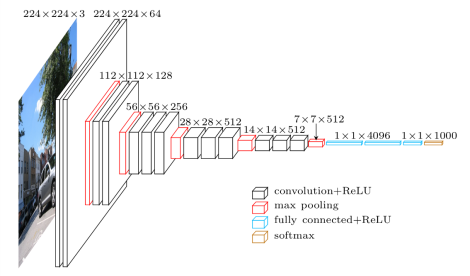 Fig. VGG16 Macroarchitecture

In [3]:
sgd = optimizers.SGD(lr=0.001, momentum=0.7)
def train_model():
    train_data = np.load(open('features_train.npy', 'rb'))
    train_labels = np.array(
        [0] * int((nb_train_samples / 2)) + [1] * int((nb_train_samples / 2)))

    validation_data = np.load(open('features_validation.npy', 'rb'))
    validation_labels = np.array(
        [0] * int((nb_validation_samples / 2)) + [1] * int((nb_validation_samples / 2)))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))

    model.compile(optimizer='sgd',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))

A small fully-connected classifier model was consequently trained on top of the pre-trained models. The features stored after running the VGG16 model, were taken as inputs into the model. 

BatchNormalization works by explicitly forcing the activations throughout a network to take on a unit gaussian distribution at the beginning of the training. It can be interpreted as doing preprocessing at every layer of the network.Dropout is implemented by only keeping a neuron active with some probability p(a hyperparameter), or setting it to zero otherwise. It can be interpreted as sampling a Neural Network within the full Neural Network, and only updating the parameters of the sampled network based on the input data. p=0.5 is a reasonable default, and was thus dropout was kept at 0.5 in the model. Loss was computed through 'binary crossentropy' since the classification was carried out between 2 classes, and stochastic gradient descent (with tunable parameters) was chosen as the optimization function. 

In [4]:
features()
train_model()

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Train on 1000 samples, validate on 200 samples
Epoch 1/10
1000/1000 [==============================] - 1s - loss: 0.6378 - acc: 0.6200 - val_loss: 0.9007 - val_acc: 0.5000
Epoch 2/10
1000/1000 [==============================] - 0s - loss: 0.4800 - acc: 0.8140 - val_loss: 0.7333 - val_acc: 0.5000
Epoch 3/10
1000/1000 [==============================] - 0s - loss: 0.4270 - acc: 0.8800 - val_loss: 0.6643 - val_acc: 0.5300
Epoch 4/10
1000/1000 [==============================] - 0s - loss: 0.4023 - acc: 0.9060 - val_loss: 0.6661 - val_acc: 0.5300
Epoch 5/10
1000/1000 [==============================] - 0s - loss: 0.3838 - acc: 0.9290 - val_loss: 0.6548 - val_acc: 0.5650
Epoch 6/10
1000/1000 [==============================] - 0s - loss: 0.3735 - acc: 0.9260 - val_loss: 0.6442 - val_acc: 0.5900
Epoch 7/10
1000/1000 [==============================] - 0s - loss: 0.3557 - acc: 0.9420 - val_loss: 0.6195 - val_acc: 0.